# Super resolution


In [ ]:
import time
import os
import copy
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import InterpolationMode

plt.ion()   # interactive mode
import torch
import numpy as np
import random



In [ ]:
# Check for the availability of a GPU, and use CPU otherwise
# If you are using Google Colab, be sure to change your runtime environment to GPU first.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Loading PascalVOC2011 dataset

In [ ]:
import os
def encode_labels(target):
    k = np.zeros((10))
    return k

In [ ]:
data_transforms = {
    'train':
    {
        'high': transforms.Compose([
            transforms.Resize((240,240), interpolation = InterpolationMode.BILINEAR),
            transforms.ToTensor(),
         ]),
        'low': transforms.Compose([
            transforms.Resize((120,120), interpolation = InterpolationMode.BILINEAR),
            transforms.Resize((240,240), interpolation = InterpolationMode.BILINEAR),
            transforms.ToTensor(),
         ]),
    },
    'val': {
        'high': transforms.Compose([
            transforms.Resize((240,240), interpolation = InterpolationMode.BILINEAR),
            transforms.ToTensor(),
         ]),
        'low': transforms.Compose([
            transforms.Resize((120,120), interpolation = InterpolationMode.BILINEAR),
            transforms.Resize((240,240), interpolation = InterpolationMode.BILINEAR),
            transforms.ToTensor(),
         ]),
    },
}

class SRDataset(Dataset):
    def __init__(self, phase, transform=None, target_transform=None, which=None):

        self.transform = transform[phase]
        self.pics = torchvision.datasets.VOCDetection(root='./data', year='2011',
                                                          image_set=phase, download=True,
                                                          transform=None,
                                                          target_transform=target_transform)
        if which is not None:
            self.pics = torch.utils.data.Subset(self.pics, which)


    def __len__(self):
        return len(self.pics)

    def __getitem__(self, idx):

        high_res = self.transform['high'](self.pics[idx][0])
        low_res = self.transform['low'](self.pics[idx][0])

        sample = (low_res, high_res)
        return sample

train_size = 4000
val_size = 400

image_datasets = {'train': SRDataset('train', data_transforms, which=(range(train_size) if train_size else None)),
                 'val': SRDataset('train', data_transforms, which=(range(val_size)) if val_size else None),}

dataset_sizes = {'train': train_size or len(image_datasets['train']),
                 'val': val_size or len(image_datasets['val'])}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=16, shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=16, shuffle=False, num_workers=2)
  }


Using downloaded and verified file: ./data/VOCtrainval_25-May-2011.tar
Extracting ./data/VOCtrainval_25-May-2011.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_25-May-2011.tar
Extracting ./data/VOCtrainval_25-May-2011.tar to ./data


In [ ]:
def imshow(inp, title=None, ax=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))

    if ax is None:
        plt.imshow(inp,)
        if title is not None:
            plt.title(title, fontsize=15)
    else:
        ax.imshow(inp)
        if title is not None:
            ax.set_title(title, fontsize=15)


torch.Size([16, 3, 240, 240]) torch.Size([16, 3, 240, 240])


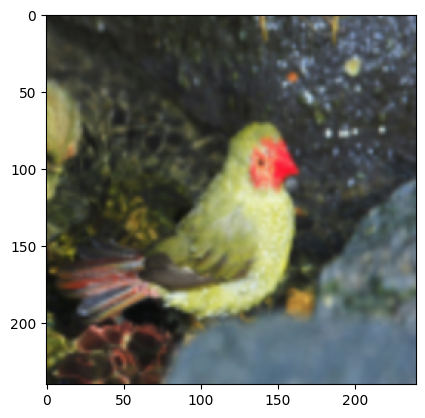

In [ ]:
for i,j in dataloaders['train']:
    print(i.shape, j.shape)
    imshow(i[0])
    break

In [ ]:
class SuperResNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, 9, padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 32, 5, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 3, 5, padding='same'),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.layers(x)


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = torch.inf

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0
            running_ae = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    preds = model(inputs).squeeze() # apply the model to the inputs.
                    loss = criterion(preds, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += (loss.item() * inputs.size(0))
                batch_ae = (preds - labels).abs().sum()
                running_ae += batch_ae

            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} ')

            dict_res[phase][0,epoch]=epoch_loss

            # Keep the results of the best model so far
            if phase == 'val' and epoch_loss < best_loss:
                best_mae = epoch_loss
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best loss: {best_mae:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, dict_res,best_mae


In [ ]:
class VGGCut(nn.Module):
    def __init__(self):
        super(VGGCut, self).__init__()

        self.vgg = models.vgg16(weights=models.VGG16_Weights).to(device).features[:23]
        for layer in self.vgg.children():
            layer.requires_grad_(False)

        self.layers_of_interest = {3, 8, 15, 22}

    def forward(self, x):
        activations = []
        for idx, layer in enumerate(self.vgg.children()):
            x = layer(x)
            if idx in self.layers_of_interest:
                activations.append(x)
        return activations


class PerceptualLoss(nn.Module):
    def __init__(self, layer_weights, perceptual_weight):
        assert len(layer_weights) == 4
        super(PerceptualLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.vgg_cut = VGGCut()
        self.layer_weights = layer_weights
        self.perceptual_weight = perceptual_weight

    def forward(self, output, target):
        perceptual = None
        loss = self.mse(output, target)
        output_activations = self.vgg_cut(output)
        target_activations = self.vgg_cut(target)

        loss = sum(self.mse(o, t) * w
                   for o, t, w
                   in zip(output_activations, target_activations, self.layer_weights))

        loss = (self.perceptual_weight * loss +
                (1-self.perceptual_weight) * self.mse(output, target))
        return loss

## Train with MSE

In [ ]:
model = SuperResNet().to(device)
criterion = nn.MSELoss()

optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=40, gamma=0.1)
num_epochs = 10

model,dict_res,best_mae = train_model(model.to(device),
                        dataloaders,
                      criterion,
                      optimizer_ft,
                      exp_lr_scheduler,
                      num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.0139 
val Loss: 0.0023 

Epoch 1/9
----------
train Loss: 0.0021 
val Loss: 0.0018 

Epoch 2/9
----------
train Loss: 0.0017 
val Loss: 0.0015 

Epoch 3/9
----------
train Loss: 0.0016 
val Loss: 0.0014 

Epoch 4/9
----------
train Loss: 0.0015 
val Loss: 0.0014 

Epoch 5/9
----------
train Loss: 0.0014 
val Loss: 0.0013 

Epoch 6/9
----------
train Loss: 0.0014 
val Loss: 0.0013 

Epoch 7/9
----------
train Loss: 0.0013 
val Loss: 0.0013 

Epoch 8/9
----------
train Loss: 0.0013 
val Loss: 0.0012 

Epoch 9/9
----------
train Loss: 0.0013 
val Loss: 0.0012 

Training complete in 5m 52s
Best loss: 0.001191


Text(0.5, 1.0, 'Train\\Validation Loss during training')

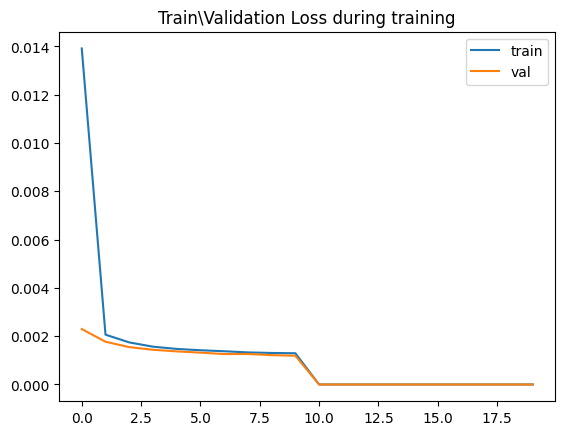

In [ ]:
pd.DataFrame({k:v.flatten() for k,v in dict_res.items()}).plot().set_title('Train\Validation Loss during training')

In [ ]:
pre, post = image_datasets['train'][6]

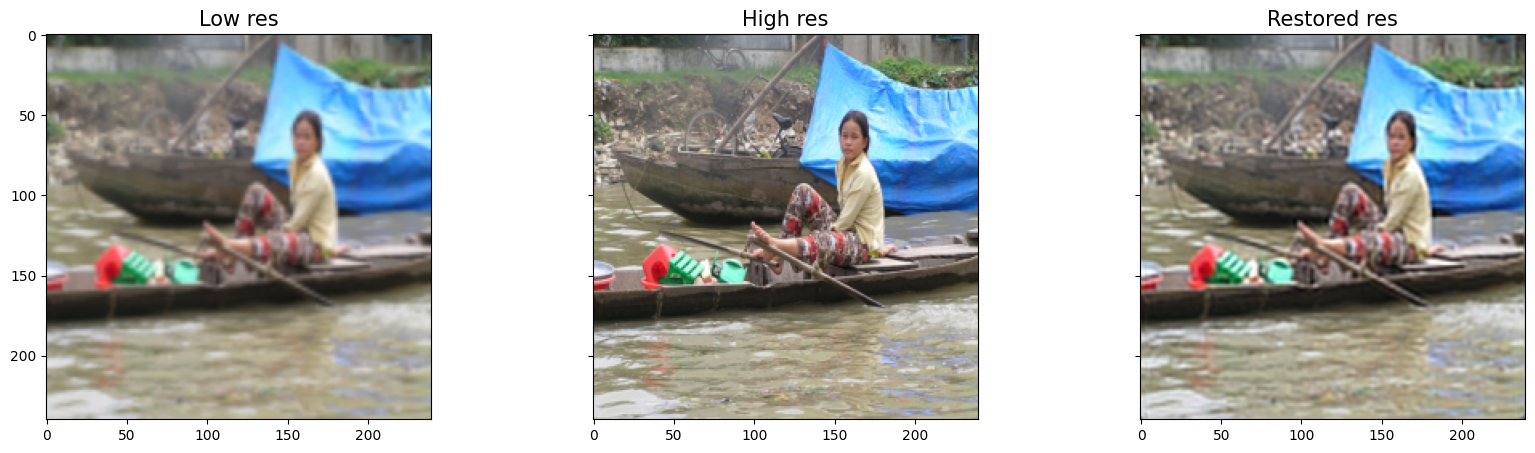

In [ ]:

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20,5))


imshow(pre.to('cpu').detach(), title='Low res', ax=axs[0])

imshow(post.to('cpu').detach(), title='High res', ax=axs[1])

imshow(model(pre.to(device)).to('cpu').detach(), title='Restored res', ax=axs[2])


## Train with perceptual loss

In [ ]:
model = SuperResNet().to(device)
criterion = PerceptualLoss([0.25, 0.25, 0.25, 0.25], 0.5)

optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=40, gamma=0.1)
num_epochs = 10

model,dict_res,best_mae = train_model(model.to(device),
                        dataloaders,
                      criterion,
                      optimizer_ft,
                      exp_lr_scheduler,
                      num_epochs=num_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------
train Loss: 0.3292 
val Loss: 0.2062 

Epoch 1/9
----------
train Loss: 0.1928 
val Loss: 0.1832 

Epoch 2/9
----------
train Loss: 0.1783 
val Loss: 0.1728 

Epoch 3/9
----------
train Loss: 0.1699 
val Loss: 0.1652 

Epoch 4/9
----------
train Loss: 0.1637 
val Loss: 0.1601 

Epoch 5/9
----------
train Loss: 0.1592 
val Loss: 0.1560 

Epoch 6/9
----------
train Loss: 0.1558 
val Loss: 0.1535 

Epoch 7/9
----------
train Loss: 0.1533 
val Loss: 0.1507 

Epoch 8/9
----------
train Loss: 0.1510 
val Loss: 0.1491 

Epoch 9/9
----------
train Loss: 0.1494 
val Loss: 0.1471 

Training complete in 5m 54s
Best loss: 0.147082


Text(0.5, 1.0, 'Train\\Validation Loss during training')

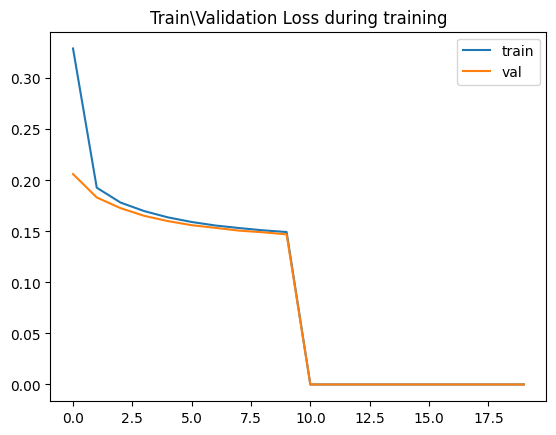

In [ ]:
pd.DataFrame({k:v.flatten() for k,v in dict_res.items()}).plot().set_title('Train\Validation Loss during training')

In [ ]:
pre, post = image_datasets['train'][6]

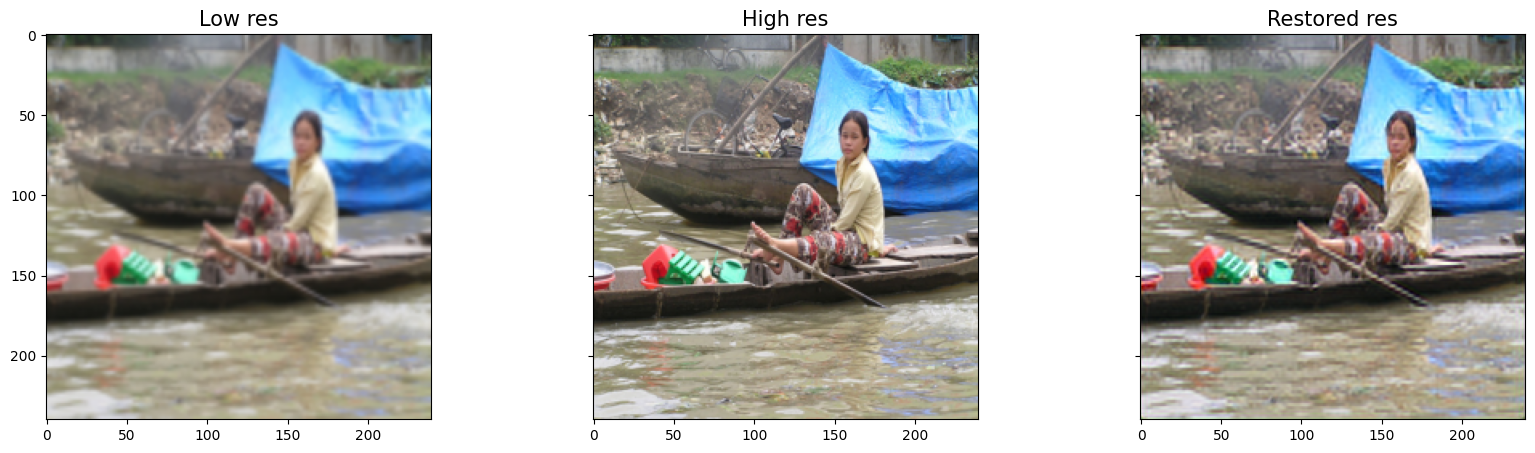

In [ ]:

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20,5))


imshow(pre.to('cpu').detach(), title='Low res', ax=axs[0])

imshow(post.to('cpu').detach(), title='High res', ax=axs[1])

imshow(model(pre.to(device)).to('cpu').detach(), title='Restored res', ax=axs[2])


In [ ]:
axs.shape

(3,)